In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_titanik.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test_titanik.csv")

In [ ]:
df_train.isnull().mean() * 100 # We determine whether there are gaps

,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.865320
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


In [ ]:
df_test.isna().mean()*100

,0
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,20.574163
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.239234
Cabin,78.229665


In [ ]:
df_train['Age'] = df_train['Age'].fillna(df_train.groupby("Survived")['Age'].transform('median')) # we group the signs and fill in the gaps with the median value

df_train = df_train.drop(['Ticket', 'Cabin', 'Embarked', 'Name'], axis = 1) # we delete unnecessary columns. Which will not be used in training

In [ ]:
df_train.isnull().mean() * 100

,0
PassengerId,0.0
Survived,0.0
Pclass,0.0
Sex,0.0
Age,0.0
SibSp,0.0
Parch,0.0
Fare,0.0


In [ ]:
df_test['Age'] = df_test['Age'].fillna(df_test.groupby("Sex")['Age'].transform('median')) # we group the signs and fill in the gaps with the median value
df_test['Fare'].fillna(df_test['Fare'].median(), inplace=True) # fill in the gaps with the median
df_test = df_test.drop(['Ticket', 'Cabin', 'Embarked', 'Name'], axis = 1)  # we delete unnecessary columns. Which will not be used in training

In [ ]:
df_test.isnull().mean() * 100

,0
PassengerId,0.0
Pclass,0.0
Sex,0.0
Age,0.0
SibSp,0.0
Parch,0.0
Fare,0.0


In [ ]:
df_train['Sex'] = df_train['Sex'].map({'male' : 0, 'female' : 1 }) # Converting categorical features into a binary value
df_test['Sex'] = df_test['Sex'].map({'male' : 0, 'female' : 1 })

In [ ]:
train_data = df_train.drop(['PassengerId'], axis=1) # Delete the column and move it to a separate dataframe, then you will need it to display the data
df_test_id = df_test['PassengerId']

<Axes: xlabel='Fare'>

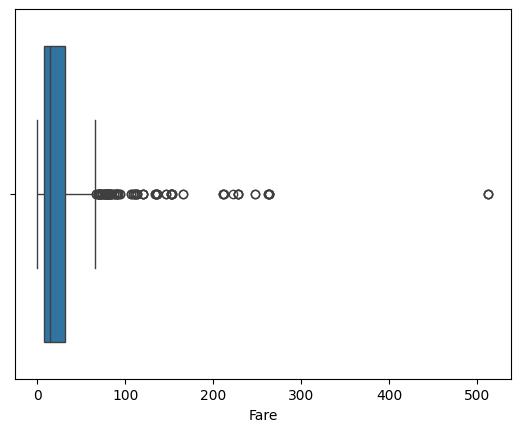

In [ ]:
sns.boxplot(x='Fare', data=df_train) #Let's look at the outliers in the data and their distribution

In [ ]:
df_train[df_train['Fare'] > 80].shape[0] #Let's look at the amount of data exceeding this value

74

Normalize Fare data. Look at the data distribution charts.

In [ ]:
#A function for determining outliers and we will log them
def outliers_z_scrole(data, feature, left = 1.5, right = 1.5):

    x = np.log(data[feature]+1)
    mean = x.mean()
    sigma = x.std()
    lower_bound = mean - sigma * left
    upper_bound = mean + sigma * right

    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return cleaned

In [ ]:
df_train_clean = outliers_z_scrole(df_train, 'Fare')

In [ ]:
df_train_clean['Fare'].shape[0]

802

<Axes: xlabel='Fare'>

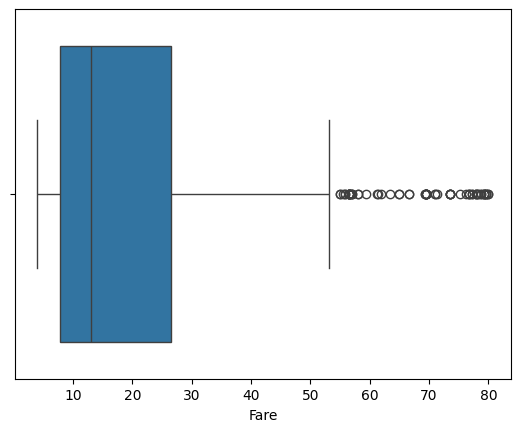

In [ ]:
sns.boxplot(x='Fare', data=df_train_clean)

<Axes: xlabel='Fare'>

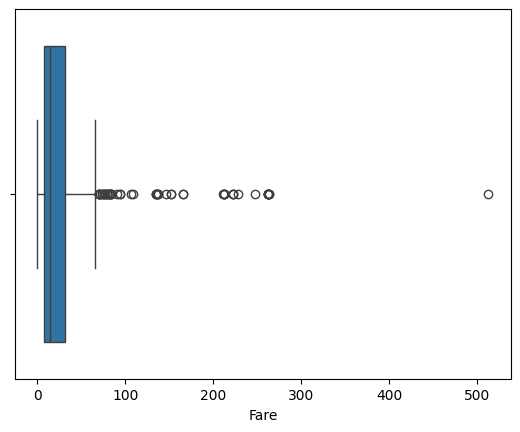

In [ ]:
sns.boxplot(x='Fare', data=df_test)

<Axes: xlabel='Fare', ylabel='Count'>

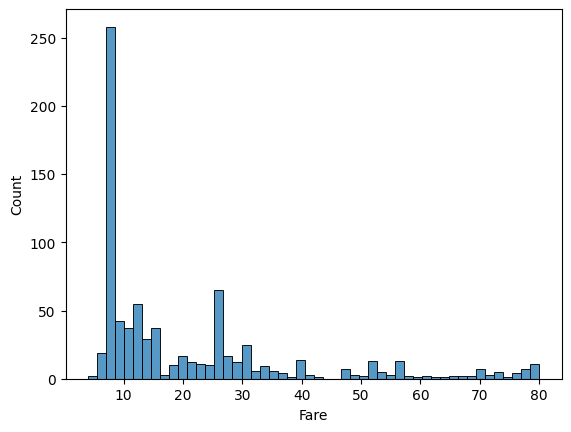

In [ ]:
sns.histplot(df_train_clean['Fare'], bins = 50) #Посмотрим на данные с помощью гистограммы

In [ ]:
df_train_clean[['Fare', 'Pclass']].corr(method='kendall') #Определим зависимость между данными методом Кендала

,Fare,Pclass
Fare,1.000000,-0.542198
Pclass,-0.542198,1.000000


In [ ]:
df_test[['Fare', 'Pclass']].corr(method='kendall')

,Fare,Pclass
Fare,1.000000,-0.629964
Pclass,-0.629964,1.000000


In [ ]:
X = df_train_clean.drop(['Survived'], axis = 1) #We delete the column of survivors and pass the values to X
y = df_train_clean["Survived"] # Assign values to the target variable y

X_train, x_val, Y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y) # We divide the data into training and validation

print(X_train.shape)
print(x_val.shape)

(561, 7)
(241, 7)


The choice of this model is due to the high accuracy of the predictions of this model. Builds a strong model based on weak ones (decision tree) improving errors at each iteration. Regularization helps to avoid overfitting. Copes well with unbalanced data. Resistant to emissions.
And it was also interesting for me personally to try this model.

In [ ]:
#We use the XGBoost model for training
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state= 34 # Shows a better value than at 42
)

xgb_model.fit(X_train, Y_train) # We train the model on training data
val_pred = xgb_model.predict(x_val) # Making a prediction based on validation data
accuracy = accuracy_score(y_val, val_pred) #passing the accuracy values of the model based on metrics

#output the values
print(f"Точность на валидационной выборке: {accuracy:.4f}\n")
print("Отчет классификации:")
print(classification_report(y_val, val_pred))
print("Матрица ошибок:")
print(confusion_matrix(y_val, val_pred))

Точность на валидационной выборке: 0.8299

Отчет классификации:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       156
           1       0.78      0.72      0.75        85

    accuracy                           0.83       241
   macro avg       0.82      0.80      0.81       241
weighted avg       0.83      0.83      0.83       241

Матрица ошибок:
[[139  17]
 [ 24  61]]


In [ ]:
xgb_model.fit(X,y)# We train the model on full-fledged data
test_predictions = xgb_model.predict(df_test) #Predictions based on a test dataframe

In [ ]:
#Creating a dataframe with predictions
output = pd.DataFrame({"PassengerId": df_test_id,
                      "Survived": test_predictions})


In [ ]:
output.to_csv('/content/drive/MyDrive/Colab Notebooks/Titanic_pred_xgb.csv', index = False)

This model does a good job of identifying people who did not survive. There is a problem with identifying survivors. I think this may be due to an imbalance in the data.